Assembling Downloaded Game Statistics
===

In [10]:
import numpy as np
import goldsberry
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",50) # Change Pandas Display Options
%matplotlib inline
goldsberry.__version__

'1.0.1'

In [11]:
SEASON_LIST = list(reversed(['2016-17','2015-16','2014-15','2013-14','2012-13']))
###
### IMPORTANT - truncate to test while data is downloading
###

In [12]:
def get_games(season):
    '''Downloads and returns as a DataFrame a set of games and basic stats for a specified season.'''
    gameids = goldsberry.GameIDs(Season=season)
    gameids = pd.DataFrame(gameids.game_list())
    return gameids

def create_stats_table(game_list):
    '''Create Statistics table
       Creates a lookup table for all the teams' cumulative stats for every date.'''
    gameids_srt = game_list.sort_values(by='GAME_DATE')
    gameids_srt['GAME_COUNT'] = 1

    all_stats = gameids_srt.groupby(['TEAM_ID','GAME_DATE','GAME_ID']).sum().groupby(level=[0]).cumsum()
    # Add GAME_ID as a column instead of an index
    all_stats.loc[(slice(None),slice(None))].reset_index(level='GAME_ID',inplace=True)
    return all_stats

def calculate_stats(stats_df, stats_type='basic'):
    '''Calculate the statistics after DataFrame has been created
       Indexed by (Team ID, Date (as a datetime object), Game_id)'''
    if stats_type=='basic':
        pct_columns = ['FG','FG3','FT']  # ==> Total Made/Total Attempted 
        avg_columns = ['AST','BLK','DREB','OREB','PF','REB','STL','TOV','FGA',"FGM",'FG3A',"FG3M",'FTA','FTM','PLUS_MINUS'] # ==> Moving Average for game n (Game 1->Game 1-n)
    elif stats_type=='advanced':
        pct_columns = []
        avg_columns = ['OFF_RATING','DEF_RATING','NET_RATING','AST_PCT','AST_TOV','AST_RATIO','OREB_PCT','DREB_PCT','REB_PCT','TM_TOV_PCT',
             'TS_PCT','EFG_PCT','PACE','PIE','USG_PCT']
    elif stats_type=='misc':
        # Put pct_columns or avg_columns for the given stats table here.
        # Just need to hard-code.
        pct_columns = []
        avg_columns = [u'BLK', u'BLKA', u'OPP_PTS_2ND_CHANCE',
                       u'OPP_PTS_FB', u'OPP_PTS_OFF_TOV', u'OPP_PTS_PAINT', u'PF', u'PFD',
                       u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_OFF_TOV', u'PTS_PAINT']
    elif stats_type=='scoring':
        pct_columns = []
        avg_columns = [u'PCT_AST_2PM', u'PCT_AST_3PM', u'PCT_AST_FGM',
                       u'PCT_FGA_2PT', u'PCT_FGA_3PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
                       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
                       u'PCT_PTS_PAINT', u'PCT_UAST_2PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM']
        
    elif stats_type=='fourfactors':
        pct_columns = []
        avg_columns = [u'FTA_RATE', u'OPP_EFG_PCT', u'OPP_FTA_RATE', u'OPP_OREB_PCT', 
                       u'OPP_TOV_PCT',u'TM_TOV_PCT']
    
    team_abbrvs = stats_df.index.levels[0]

    # Loop over all teams
    for team in team_abbrvs:
        for col in avg_columns: # running average
            stats_df.loc[(team, slice(None)),col+'_mean'] = stats_df.loc[(team, slice(None)),col].shift(1) / stats_df.loc[(team, slice(None)),'GAME_COUNT'].shift(1)
        for col in pct_columns: # made/attempted
            stats_df.loc[(team, slice(None)),col+'_pct'] = stats_df.loc[(team, slice(None)), col+'M'].shift(1) / stats_df.loc[(team, slice(None)), col+'A'].shift(1)
    
    return stats_df

In [19]:
# RUN THIS TO GENERATE FINAL TABLE
# For each season, join each data table based on TEAM_ID and GAME_ID
# after calculating statistics based on TEAM_ID and GAME_DATE.

final_seasons = {}

for season in SEASON_LIST:
    print "processing season {}...".format(season)
    # Download a set of games
    games = get_games(season)
    # Make GAME_ID an integer for consistency
    games['GAME_ID'] = games['GAME_ID'].astype(int)
    # Create stats lookup table
    stats_tbl = create_stats_table(games)
    stats_tbl = calculate_stats(stats_tbl, stats_type='basic').reset_index(level=['TEAM_ID','GAME_DATE'])
    
    joined_data = games.set_index(['TEAM_ID','GAME_ID']).join(stats_tbl.set_index(['TEAM_ID','GAME_ID']),
                                                                        lsuffix='',rsuffix='_R')
    joined_data.reset_index(inplace=True)
    for stats_type in ('advanced','fourfactors','misc','scoring'):
        #print "processing {} {}".format(stats_type, season)
        # load in the data
        games_stats = pd.read_csv('{}_{}.csv'.format(stats_type.title(), season))
        # append a game_date column to game_id
        id_to_date = pd.Series(games['GAME_DATE'].values, index=games['GAME_ID']).to_dict()
        games_stats['GAME_DATE'] = games_stats['GAME_ID'].map(id_to_date)
        
        curr_stats_tbl = create_stats_table(games_stats)
        
        curr_stats_tbl = calculate_stats(curr_stats_tbl, stats_type=stats_type).reset_index(level=['TEAM_ID','GAME_DATE'])
        
        joined_data = joined_data.set_index(['TEAM_ID','GAME_ID']).join(curr_stats_tbl.set_index(['TEAM_ID','GAME_ID']),
                                                                                  lsuffix='',rsuffix='_R')
        joined_data.reset_index(inplace=True)
    
    # Add target columns from the original game list
    del joined_data['PLUS_MINUS']
    target = games.set_index(['TEAM_ID','GAME_ID'])['PLUS_MINUS']
    
    joined_data = joined_data.set_index(['TEAM_ID','GAME_ID']).join(target, lsuffix='', rsuffix='_TARGET').reset_index()
    
    final_seasons[season] = joined_data
    print "done with season {}".format(season)
# All done!
print "done!"

processing season 2012-13...
done with season 2012-13
processing season 2013-14...
done with season 2013-14
processing season 2014-15...
done with season 2014-15
processing season 2015-16...
done with season 2015-16
processing season 2016-17...
done with season 2016-17
done!


In [33]:
final_seasons['2012-13']

,TEAM_ID,GAME_ID,AST,BLK,DREB,FG3A,FG3M,FG3_PCT,FGA,FGM,FG_PCT,FTA,FTM,FT_PCT,GAME_DATE,MATCHUP,MIN,OREB,PF,PTS,REB,SEASON_ID,STL,TEAM_ABBREVIATION,TEAM_NAME,...,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,PCT_AST_2PM_mean,PCT_AST_3PM_mean,PCT_AST_FGM_mean,PCT_FGA_2PT_mean,PCT_FGA_3PT_mean,PCT_PTS_2PT_mean,PCT_PTS_2PT_MR_mean,PCT_PTS_3PT_mean,PCT_PTS_FB_mean,PCT_PTS_FT_mean,PCT_PTS_OFF_TOV_mean,PCT_PTS_PAINT_mean,PCT_UAST_2PM_mean,PCT_UAST_3PM_mean,PCT_UAST_FGM_mean,PLUS_MINUS
0,1610612748,21200845,35,9,33,23,10,0.435,101,56,0.554,24,19,0.792,2013-02-26,MIA vs. SAC,290,8,22,141,41,22012,13,MIA,Miami Heat,...,10.187,12.977,6.938,9.151,10.101,22.684,27.405,8.242,23.365,0.500574,0.849222,0.574259,0.731000,0.269019,0.596630,0.185500,0.236370,0.125722,0.166963,0.183648,0.411148,0.499444,0.150778,0.425741,12
1,1610612743,21201144,40,4,33,25,11,0.440,99,54,0.545,21,13,0.619,2013-04-06,DEN vs. HOU,240,13,26,132,46,22012,12,DEN,Denver Nuggets,...,7.831,13.692,14.303,13.301,14.407,42.169,34.638,9.778,30.949,0.548224,0.846224,0.596197,0.783039,0.217000,0.649342,0.101842,0.176868,0.184711,0.173724,0.186382,0.547474,0.451789,0.127461,0.403816,18
2,1610612757,21200923,27,6,30,21,13,0.619,86,53,0.616,21,17,0.810,2013-03-08,POR @ SAS,240,8,17,136,38,22012,8,POR,Portland Trail Blazers,...,12.669,15.050,5.949,10.264,9.675,23.016,29.039,11.474,25.076,0.526433,0.793383,0.590250,0.712683,0.287350,0.584900,0.207717,0.246050,0.097067,0.168983,0.158917,0.377233,0.473567,0.189950,0.409750,30
3,1610612746,21201121,39,5,24,21,9,0.429,93,52,0.559,18,13,0.722,2013-04-03,LAC vs. PHX,240,13,23,126,37,22012,14,LAC,Los Angeles Clippers,...,12.739,16.892,11.751,12.545,14.921,33.825,34.229,9.783,29.437,0.547347,0.871040,0.610840,0.734760,0.265280,0.611733,0.168373,0.222373,0.154040,0.165893,0.195347,0.443387,0.452667,0.128960,0.389160,25
4,1610612739,21200724,33,5,35,24,9,0.375,92,52,0.565,13,9,0.692,2013-02-06,CLE vs. CHA,240,10,20,122,45,22012,6,CLE,Cleveland Cavaliers,...,9.192,11.016,5.507,8.525,8.850,20.272,25.132,8.468,21.748,0.484167,0.830521,0.554521,0.756438,0.243563,0.599000,0.185354,0.224896,0.113187,0.176062,0.180625,0.413792,0.515833,0.169479,0.445479,27
5,1610612753,21201166,27,3,44,15,8,0.533,109,51,0.468,8,3,0.375,2013-04-10,ORL vs. MIL,265,18,19,113,62,22012,6,ORL,Orlando Magic,...,16.471,15.431,8.422,10.451,11.892,36.643,34.620,12.878,31.301,0.563026,0.836500,0.604756,0.773885,0.226154,0.671179,0.209128,0.195115,0.106846,0.133641,0.151333,0.462064,0.436987,0.163500,0.395256,10
6,1610612749,21201102,32,2,31,27,14,0.519,100,51,0.510,17,15,0.882,2013-04-01,MIL vs. CHA,240,14,21,131,45,22012,7,MIL,Milwaukee Bucks,...,14.572,15.243,9.971,11.514,13.324,31.677,32.833,14.849,29.441,0.550417,0.795750,0.596292,0.778694,0.221306,0.634472,0.200056,0.207250,0.136889,0.158319,0.181764,0.434444,0.449639,0.204250,0.403722,29
7,1610612742,21200996,33,3,29,22,13,0.591,89,51,0.573,14,12,0.857,2013-03-18,DAL @ ATL,240,10,20,127,39,22012,7,DAL,Dallas Mavericks,...,14.618,14.696,11.177,11.011,10.609,26.670,31.298,9.703,27.073,0.531788,0.841333,0.595152,0.761106,0.238939,0.616439,0.217667,0.218015,0.168273,0.165409,0.158470,0.398848,0.468227,0.143515,0.404848,14
8,1610612759,21200872,41,6,34,20,9,0.450,84,51,0.607,23,19,0.826,2013-03-01,SAS vs. SAC,240,9,15,130,43,22012,12,SAS,San Antonio Spurs,...,10.276,14.202,7.998,9.942,10.036,25.574,26.377,5.449,21.891,0.556966,0.907661,0.632322,0.728237,0.271814,0.596780,0.171831,0.237186,0.133339,0.166034,0.166712,0.424847,0.443034,0.092356,0.367712,28
9,1610612761,21200095,31,5,32,24,8,0.333,108,51,0.472,30,23,0.767,2012-11-12,TOR vs. UTA,315,20,31,133,52,22012,13,TOR,Toronto Raptors,...,1.354,1.698,0.628,1.320,1.304,2.631,3.573,1.244,2.992,0.478167,0.813500,0.566667,0.733667,0.266333,0.556333,0.185500,0.253000,0.095833,0.191167,0.198500,0.370833,0.521833,0.186500,0.433333,-7


In [35]:
final_games = {}

for season in SEASON_LIST:
    joined_data = final_seasons[season]

    print "processing season {}".format(season)
    # Create a new dataframe with home team and away team stats
    final_df = pd.DataFrame(columns=[colname+'_HOME' for colname in joined_data.columns] + \
                                    [colname+'_AWAY' for colname in joined_data.columns],
                            index=joined_data['GAME_ID'].unique())
    home_cols = [colname+'_HOME' for colname in joined_data.columns]
    away_cols = [colname+'_AWAY' for colname in joined_data.columns]
    
    for i, gid in enumerate(joined_data['GAME_ID'].unique()):
        # first, find home team
        if i % (joined_data.shape[0]/(2*4)) == 0:
            print '{:.1f}%'.format(2*100*float(i)/joined_data.shape[0])
        
        home_data = joined_data[(joined_data['GAME_ID']==gid) & (joined_data['MATCHUP'].str.contains('vs.'))].copy()
        home_data.columns = home_cols
        #print home_data.head()
        away_data = joined_data[(joined_data['GAME_ID']==gid) & (joined_data['MATCHUP'].str.contains('@'))].copy()
        away_data.columns = away_cols
        
        final_df.ix[gid, home_cols] = home_data[home_cols].values
        final_df.ix[gid, away_cols] = away_data[away_cols].values
    
    # Tidying up
    final_df.index.name = 'GAME_ID'
    final_games[season] = final_df
    
print "done!"

processing season 2012-13
0.0%
25.0%
49.9%
74.9%
99.8%
processing season 2013-14
0.0%
25.0%
49.9%
74.9%
99.8%
processing season 2014-15
0.0%
25.0%
49.9%
74.9%
99.8%
processing season 2015-16
0.0%
25.0%
49.9%
74.9%
99.8%
processing season 2016-17
0.0%
25.0%
49.9%
74.9%
99.8%
done!


### Looking at the data
Now that everything is loaded into the `final_games` dict, let's peek inside.

In [37]:
print "Seasons available: ", ' '.join(final_games.keys())
print "shape 2012-13:", final_games['2012-13'].shape
final_games['2014-15'].head()

Seasons available:  2015-16 2012-13 2016-17 2013-14 2014-15
shape 2012-13: (1230, 352)


,TEAM_ID_HOME,GAME_ID_HOME,AST_HOME,BLK_HOME,DREB_HOME,FG3A_HOME,FG3M_HOME,FG3_PCT_HOME,FGA_HOME,FGM_HOME,FG_PCT_HOME,FTA_HOME,FTM_HOME,FT_PCT_HOME,GAME_DATE_HOME,MATCHUP_HOME,MIN_HOME,OREB_HOME,PF_HOME,PTS_HOME,REB_HOME,SEASON_ID_HOME,STL_HOME,TEAM_ABBREVIATION_HOME,TEAM_NAME_HOME,...,PCT_PTS_2PT_MR_AWAY,PCT_PTS_3PT_AWAY,PCT_PTS_FB_AWAY,PCT_PTS_FT_AWAY,PCT_PTS_OFF_TOV_AWAY,PCT_PTS_PAINT_AWAY,PCT_UAST_2PM_AWAY,PCT_UAST_3PM_AWAY,PCT_UAST_FGM_AWAY,PCT_AST_2PM_mean_AWAY,PCT_AST_3PM_mean_AWAY,PCT_AST_FGM_mean_AWAY,PCT_FGA_2PT_mean_AWAY,PCT_FGA_3PT_mean_AWAY,PCT_PTS_2PT_mean_AWAY,PCT_PTS_2PT_MR_mean_AWAY,PCT_PTS_3PT_mean_AWAY,PCT_PTS_FB_mean_AWAY,PCT_PTS_FT_mean_AWAY,PCT_PTS_OFF_TOV_mean_AWAY,PCT_PTS_PAINT_mean_AWAY,PCT_UAST_2PM_mean_AWAY,PCT_UAST_3PM_mean_AWAY,PCT_UAST_FGM_mean_AWAY,PLUS_MINUS_AWAY
GAME_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21401184,1610612743,21401184,29,1,34,43,15,0.349,125,53,0.424,25,22,0.88,2015-04-10,DEN vs. DAL,290,27,26,143,61,22014,10,DEN,Denver Nuggets,...,14.401,19.961,12.011,12.604,14.604,32.036,40.922,12.013,34.434,0.480141,0.847154,0.56259,0.701615,0.298423,0.587141,0.182308,0.252974,0.151936,0.159897,0.185449,0.404846,0.519897,0.152846,0.43741,1
21401120,1610612760,21401120,23,1,31,31,14,0.452,93,45,0.484,33,27,0.818,2015-04-01,OKC vs. DAL,240,15,21,131,46,22014,4,OKC,Oklahoma City Thunder,...,13.765,19.3,11.285,11.808,13.951,30.129,38.797,11.589,32.552,0.481216,0.843392,0.565176,0.697189,0.302851,0.582743,0.182811,0.259608,0.150892,0.157662,0.186622,0.399946,0.518824,0.156608,0.434824,4
21400128,1610612740,21400128,31,3,31,20,15,0.75,84,56,0.667,16,12,0.75,2014-11-14,NOP vs. MIN,240,3,30,139,34,22014,13,NOP,New Orleans Pelicans,...,1.897,1.154,1.243,1.713,1.465,3.236,4.044,1.393,3.692,0.504714,0.848571,0.551429,0.838857,0.161143,0.651429,0.245857,0.150714,0.144571,0.197571,0.188857,0.405714,0.495286,0.151429,0.448571,-48
21400939,1610612737,21400939,42,6,23,36,20,0.556,88,53,0.602,7,4,0.571,2015-03-09,ATL vs. SAC,240,10,18,130,33,22014,8,ATL,Atlanta Hawks,...,10.963,9.682,8.799,14.011,9.321,27.346,31.604,10.17,28.479,0.490902,0.818934,0.540721,0.803574,0.196443,0.618377,0.178164,0.154967,0.142066,0.226721,0.150623,0.44018,0.509115,0.164672,0.459295,-25
21401222,1610612750,21401222,22,4,25,19,6,0.316,84,39,0.464,35,29,0.829,2015-04-15,MIN vs. OKC,240,14,23,113,39,22014,12,MIN,Minnesota Timberwolves,...,13.802,18.188,13.326,14.593,12.218,35.409,43.888,16.435,38.486,0.466519,0.800185,0.532,0.737951,0.262049,0.600457,0.168963,0.221321,0.162198,0.178198,0.148877,0.43142,0.533494,0.199815,0.468012,25


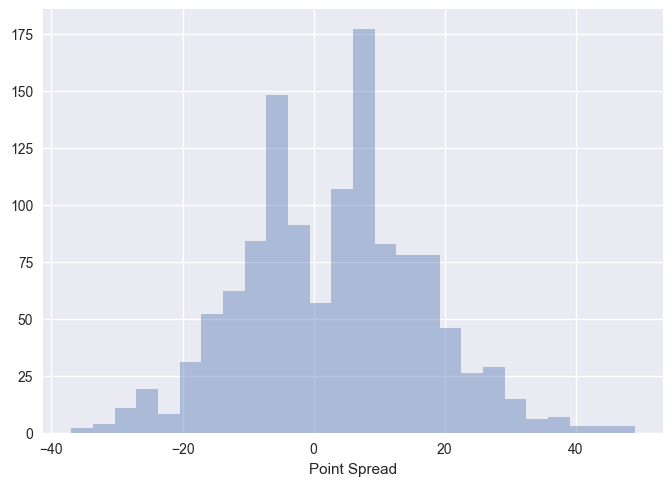

In [9]:
import seaborn as sns
sns.distplot(final_games['2012-13']['PLUS_MINUS_HOME'], norm_hist=False, kde=False)
plt.xlabel('Point Spread')

In [38]:
output = pd.DataFrame()
for season, df in final_games.iteritems():
    output = pd.concat([output, df])
    
output.shape

(6150, 352)

In [40]:
output.to_csv('final.csv')

In [41]:
# Get rid of redundant columns
# Construct all the features we want
cols_to_keep = ['GAME_DATE_HOME','MATCHUP_HOME','PLUS_MINUS_HOME','PLUS_MINUS_AWAY']
cols_to_keep += [c for c in output.columns if 'TEAM' in c \
               or 'mean' in c or 'pct' in c]
# Keep the tabulated statistics

output_clean = output[cols_to_keep]

output_clean.to_csv('final_clean.csv')